# Method 8 - Best Fresh Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Novus HFU

novus_hfu = hfu.get_novus_hfu()

# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

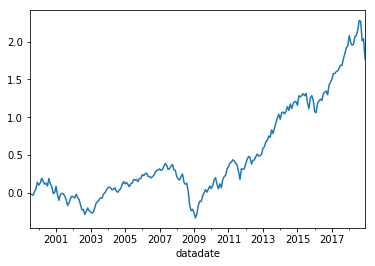

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.139887
2000-12-31   -0.121033
2001-12-31   -0.046620
2002-12-31   -0.201029
2003-12-31    0.356672
2004-12-31    0.107372
2005-12-31    0.037753
2006-12-31    0.091916
2007-12-31   -0.003347
2008-12-31   -0.395283
2009-12-31    0.389499
2010-12-31    0.209887
2011-12-31    0.001095
2012-12-31    0.143797
2013-12-31    0.353798
2014-12-31    0.080497
2015-12-31    0.007760
2016-12-31    0.109197
2017-12-31    0.193667
2018-12-31   -0.057167
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1716.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.16e-169
Time:                        07:23:46   Log-Likelihood:                 801.38
No. Observations:                 234   AIC:                            -1593.
Df Residuals:                     229   BIC:                            -1575.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.666      0.008       0.000       0.003
mktrf          0.9549      0.015     64.293      0.000       0.926       0.984
me             0.0578      0.017      3.347      0.001       0.024       0.092
ia             0.0119      0.026      0.452      0.652      -0.040       0.064
roe           -0.0474      0.022     -2.107      0.036      -0.092      -0.003
==============================================================================
Omnibus:                       69.042   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.144
Skew:                           0.804   Prob(JB):                    9.24e-153
Kurtosis:                      11.320   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     3386.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.19e-202
Time:                        07:23:46   Log-Likelihood:                 801.38
No. Observations:                 234   AIC:                            -1593.
Df Residuals:                     229   BIC:                            -1575.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.259      0.024       0.000       0.003
mktrf          0.9549      0.019     50.093      0.000       0.918       0.992
me             0.0578      0.050      1.162      0.245      -0.040       0.155
ia             0.0119      0.049      0.241      0.809      -0.085       0.108
roe           -0.0474      0.042     -1.119      0.263      -0.130       0.036
==============================================================================
Omnibus:                       69.042   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.144
Skew:                           0.804   Prob(JB):                    9.24e-153
Kurtosis:                      11.320   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     3747.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.39e-207
Time:                        07:23:46   Log-Likelihood:                 801.38
No. Observations:                 234   AIC:                            -1593.
Df Residuals:                     229   BIC:                            -1575.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.165      0.030       0.000       0.003
mktrf          0.9549      0.016     60.753      0.000       0.924       0.986
me             0.0578      0.053      1.084      0.278      -0.047       0.162
ia             0.0119      0.040      0.295      0.768      -0.067       0.091
roe           -0.0474      0.039     -1.224      0.221      -0.123       0.028
==============================================================================
Omnibus:                       69.042   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.144
Skew:                           0.804   Prob(JB):                    9.24e-153
Kurtosis:                      11.320   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1307.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.34e-165
Time:                        07:23:46   Log-Likelihood:                 796.30
No. Observations:                 234   AIC:                            -1581.
Df Residuals:                     228   BIC:                            -1560.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.755      0.081      -0.000       0.002
mktrf          0.9685      0.015     63.544      0.000       0.939       0.999
smb            0.1102      0.020      5.480      0.000       0.071       0.150
hml            0.0552      0.024      2.328      0.021       0.008       0.102
rmw            0.0239      0.027      0.891      0.374      -0.029       0.077
cma           -0.0887      0.034     -2.603      0.010      -0.156      -0.022
==============================================================================
Omnibus:                       84.068   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.787
Skew:                           1.093   Prob(JB):                    4.34e-178
Kurtosis:                      11.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1372.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.17e-168
Time:                        07:23:46   Log-Likelihood:                 796.30
No. Observations:                 234   AIC:                            -1581.
Df Residuals:                     228   BIC:                            -1560.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.628      0.103      -0.000       0.002
mktrf          0.9685      0.016     59.306      0.000       0.937       1.001
smb            0.1102      0.043      2.572      0.010       0.026       0.194
hml            0.0552      0.042      1.323      0.186      -0.027       0.137
rmw            0.0239      0.025      0.964      0.335      -0.025       0.072
cma           -0.0887      0.049     -1.798      0.072      -0.185       0.008
==============================================================================
Omnibus:                       84.068   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.787
Skew:                           1.093   Prob(JB):                    4.34e-178
Kurtosis:                      11.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1602.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.29e-175
Time:                        07:23:46   Log-Likelihood:                 796.30
No. Observations:                 234   AIC:                            -1581.
Df Residuals:                     228   BIC:                            -1560.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.493      0.135      -0.000       0.002
mktrf          0.9685      0.017     56.110      0.000       0.935       1.002
smb            0.1102      0.041      2.657      0.008       0.029       0.191
hml            0.0552      0.036      1.516      0.129      -0.016       0.127
rmw            0.0239      0.025      0.974      0.330      -0.024       0.072
cma           -0.0887      0.043     -2.075      0.038      -0.172      -0.005
==============================================================================
Omnibus:                       84.068   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              816.787
Skew:                           1.093   Prob(JB):                    4.34e-178
Kurtosis:                      11.888   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1841.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.97e-173
Time:                        07:23:47   Log-Likelihood:                 809.35
No. Observations:                 234   AIC:                            -1609.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.705      0.007       0.000       0.002
mktrf          0.9393      0.013     71.061      0.000       0.913       0.965
smb            0.1084      0.016      6.568      0.000       0.076       0.141
hml            0.0274      0.016      1.670      0.096      -0.005       0.060
umd           -0.0687      0.011     -6.391      0.000      -0.090      -0.048
==============================================================================
Omnibus:                       33.791   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.782
Skew:                           0.369   Prob(JB):                     3.69e-37
Kurtosis:                       7.082   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     2028.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.88e-177
Time:                        07:23:47   Log-Likelihood:                 809.35
No. Observations:                 234   AIC:                            -1609.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.145      0.032       0.000       0.003
mktrf          0.9393      0.016     59.073      0.000       0.908       0.970
smb            0.1084      0.039      2.757      0.006       0.031       0.185
hml            0.0274      0.024      1.156      0.248      -0.019       0.074
umd           -0.0687      0.025     -2.757      0.006      -0.118      -0.020
==============================================================================
Omnibus:                       33.791   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.782
Skew:                           0.369   Prob(JB):                     3.69e-37
Kurtosis:                       7.082   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     2053.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.78e-178
Time:                        07:23:47   Log-Likelihood:                 809.35
No. Observations:                 234   AIC:                            -1609.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.926      0.054   -2.48e-05       0.003
mktrf          0.9393      0.015     61.322      0.000       0.909       0.969
smb            0.1084      0.037      2.953      0.003       0.036       0.180
hml            0.0274      0.022      1.265      0.206      -0.015       0.070
umd           -0.0687      0.024     -2.862      0.004      -0.116      -0.022
==============================================================================
Omnibus:                       33.791   Durbin-Watson:                   1.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.782
Skew:                           0.369   Prob(JB):                     3.69e-37
Kurtosis:                       7.082   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     689.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.44e-79
Time:                        07:23:47   Log-Likelihood:                 384.91
No. Observations:                 120   AIC:                            -759.8
Df Residuals:                     115   BIC:                            -745.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.202      0.030       0.000       0.004
mktrf          0.9451      0.026     36.673      0.000       0.894       0.996
me             0.0160      0.025      0.627      0.532      -0.034       0.066
ia             0.0124      0.040      0.312      0.756      -0.067       0.091
roe           -0.0677      0.035     -1.919      0.057      -0.138       0.002
==============================================================================
Omnibus:                       32.615   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.856
Skew:                           0.830   Prob(JB):                     6.34e-29
Kurtosis:                       7.818   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1634.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.70e-100
Time:                        07:23:47   Log-Likelihood:                 384.91
No. Observations:                 120   AIC:                            -759.8
Df Residuals:                     115   BIC:                            -745.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.754      0.079      -0.000       0.004
mktrf          0.9451      0.025     37.371      0.000       0.896       0.995
me             0.0160      0.054      0.295      0.768      -0.090       0.122
ia             0.0124      0.060      0.207      0.836      -0.105       0.130
roe           -0.0677      0.054     -1.244      0.213      -0.174       0.039
==============================================================================
Omnibus:                       32.615   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.856
Skew:                           0.830   Prob(JB):                     6.34e-29
Kurtosis:                       7.818   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2247.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.93e-108
Time:                        07:23:47   Log-Likelihood:                 384.91
No. Observations:                 120   AIC:                            -759.8
Df Residuals:                     115   BIC:                            -745.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.534      0.125      -0.001       0.005
mktrf          0.9451      0.018     53.977      0.000       0.911       0.979
me             0.0160      0.059      0.270      0.787      -0.100       0.132
ia             0.0124      0.050      0.246      0.806      -0.086       0.111
roe           -0.0677      0.048     -1.403      0.161      -0.162       0.027
==============================================================================
Omnibus:                       32.615   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.856
Skew:                           0.830   Prob(JB):                     6.34e-29
Kurtosis:                       7.818   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     474.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.58e-74
Time:                        07:23:47   Log-Likelihood:                 376.75
No. Observations:                 120   AIC:                            -741.5
Df Residuals:                     114   BIC:                            -724.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.751      0.083      -0.000       0.004
mktrf          0.9998      0.029     34.223      0.000       0.942       1.058
smb            0.0939      0.033      2.838      0.005       0.028       0.159
hml            0.0219      0.041      0.540      0.590      -0.058       0.102
rmw            0.0608      0.048      1.272      0.206      -0.034       0.156
cma           -0.0674      0.052     -1.287      0.201      -0.171       0.036
==============================================================================
Omnibus:                       31.904   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.042
Skew:                           0.813   Prob(JB):                     7.04e-28
Kurtosis:                       7.729   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     691.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.71e-83
Time:                        07:23:47   Log-Likelihood:                 376.75
No. Observations:                 120   AIC:                            -741.5
Df Residuals:                     114   BIC:                            -724.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.667      0.096      -0.000       0.004
mktrf          0.9998      0.032     31.690      0.000       0.938       1.062
smb            0.0939      0.060      1.564      0.118      -0.024       0.212
hml            0.0219      0.060      0.367      0.713      -0.095       0.139
rmw            0.0608      0.051      1.186      0.236      -0.040       0.161
cma           -0.0674      0.067     -1.009      0.313      -0.198       0.064
==============================================================================
Omnibus:                       31.904   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.042
Skew:                           0.813   Prob(JB):                     7.04e-28
Kurtosis:                       7.729   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     927.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.51e-90
Time:                        07:23:47   Log-Likelihood:                 376.75
No. Observations:                 120   AIC:                            -741.5
Df Residuals:                     114   BIC:                            -724.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.464      0.143      -0.001       0.004
mktrf          0.9998      0.034     29.639      0.000       0.934       1.066
smb            0.0939      0.058      1.624      0.104      -0.019       0.207
hml            0.0219      0.054      0.403      0.687      -0.085       0.129
rmw            0.0608      0.054      1.133      0.257      -0.044       0.166
cma           -0.0674      0.057     -1.182      0.237      -0.179       0.044
==============================================================================
Omnibus:                       31.904   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.042
Skew:                           0.813   Prob(JB):                     7.04e-28
Kurtosis:                       7.729   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     711.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.22e-80
Time:                        07:23:47   Log-Likelihood:                 386.75
No. Observations:                 120   AIC:                            -763.5
Df Residuals:                     115   BIC:                            -749.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.622      0.010       0.001       0.004
mktrf          0.9350      0.022     41.817      0.000       0.891       0.979
smb            0.0904      0.025      3.551      0.001       0.040       0.141
hml            0.0195      0.025      0.766      0.445      -0.031       0.070
umd           -0.0819      0.016     -5.208      0.000      -0.113      -0.051
==============================================================================
Omnibus:                        5.814   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                9.027
Skew:                           0.064   Prob(JB):                       0.0110
Kurtosis:                       4.338   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     936.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.03e-86
Time:                        07:23:47   Log-Likelihood:                 386.75
No. Observations:                 120   AIC:                            -763.5
Df Residuals:                     115   BIC:                            -749.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.278      0.023       0.000       0.005
mktrf          0.9350      0.025     37.267      0.000       0.886       0.984
smb            0.0904      0.044      2.043      0.041       0.004       0.177
hml            0.0195      0.028      0.691      0.490      -0.036       0.075
umd           -0.0819      0.027     -3.043      0.002      -0.135      -0.029
==============================================================================
Omnibus:                        5.814   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                9.027
Skew:                           0.064   Prob(JB):                       0.0110
Kurtosis:                       4.338   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1119.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.74e-91
Time:                        07:23:47   Log-Likelihood:                 386.75
No. Observations:                 120   AIC:                            -763.5
Df Residuals:                     115   BIC:                            -749.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.998      0.046    4.57e-05       0.005
mktrf          0.9350      0.025     37.745      0.000       0.886       0.984
smb            0.0904      0.041      2.181      0.029       0.009       0.172
hml            0.0195      0.028      0.708      0.479      -0.035       0.074
umd           -0.0819      0.025     -3.288      0.001      -0.131      -0.033
==============================================================================
Omnibus:                        5.814   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                9.027
Skew:                           0.064   Prob(JB):                       0.0110
Kurtosis:                       4.338   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2089.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.32e-102
Time:                        07:23:47   Log-Likelihood:                 462.16
No. Observations:                 114   AIC:                            -914.3
Df Residuals:                     109   BIC:                            -900.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.779      0.006       0.000       0.002
mktrf          0.9395      0.013     74.423      0.000       0.914       0.965
me             0.1757      0.019      9.013      0.000       0.137       0.214
ia            -0.0089      0.027     -0.329      0.743      -0.062       0.045
roe           -0.0230      0.024     -0.969      0.335      -0.070       0.024
==============================================================================
Omnibus:                        0.747   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.688   Jarque-Bera (JB):                0.495
Skew:                          -0.157   Prob(JB):                        0.781
Kurtosis:                       3.077   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3535.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.49e-114
Time:                        07:23:47   Log-Likelihood:                 462.16
No. Observations:                 114   AIC:                            -914.3
Df Residuals:                     109   BIC:                            -900.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.932      0.003       0.000       0.002
mktrf          0.9395      0.012     77.816      0.000       0.916       0.963
me             0.1757      0.019      9.472      0.000       0.139       0.212
ia            -0.0089      0.034     -0.261      0.794      -0.076       0.058
roe           -0.0230      0.019     -1.221      0.222      -0.060       0.014
==============================================================================
Omnibus:                        0.747   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.688   Jarque-Bera (JB):                0.495
Skew:                          -0.157   Prob(JB):                        0.781
Kurtosis:                       3.077   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     5096.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.31e-123
Time:                        07:23:47   Log-Likelihood:                 462.16
No. Observations:                 114   AIC:                            -914.3
Df Residuals:                     109   BIC:                            -900.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      3.395      0.001       0.001       0.002
mktrf          0.9395      0.011     86.253      0.000       0.918       0.961
me             0.1757      0.017     10.410      0.000       0.143       0.209
ia            -0.0089      0.034     -0.262      0.794      -0.076       0.058
roe           -0.0230      0.017     -1.351      0.177      -0.056       0.010
==============================================================================
Omnibus:                        0.747   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.688   Jarque-Bera (JB):                0.495
Skew:                          -0.157   Prob(JB):                        0.781
Kurtosis:                       3.077   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2702.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.12e-111
Time:                        07:23:47   Log-Likelihood:                 489.79
No. Observations:                 114   AIC:                            -967.6
Df Residuals:                     108   BIC:                            -951.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.420      0.159      -0.000       0.001
mktrf          0.9371      0.009     98.723      0.000       0.918       0.956
smb            0.1551      0.015     10.066      0.000       0.125       0.186
hml            0.0531      0.020      2.704      0.008       0.014       0.092
rmw           -0.0478      0.024     -1.986      0.050      -0.096      -0.000
cma           -0.0836      0.031     -2.736      0.007      -0.144      -0.023
==============================================================================
Omnibus:                        1.233   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                0.790
Skew:                           0.166   Prob(JB):                        0.674
Kurtosis:                       3.238   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2366.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.35e-108
Time:                        07:23:47   Log-Likelihood:                 489.79
No. Observations:                 114   AIC:                            -967.6
Df Residuals:                     108   BIC:                            -951.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.176      0.240      -0.000       0.001
mktrf          0.9371      0.011     85.394      0.000       0.916       0.959
smb            0.1551      0.014     11.400      0.000       0.128       0.182
hml            0.0531      0.020      2.597      0.009       0.013       0.093
rmw           -0.0478      0.024     -1.983      0.047      -0.095      -0.001
cma           -0.0836      0.030     -2.771      0.006      -0.143      -0.024
==============================================================================
Omnibus:                        1.233   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                0.790
Skew:                           0.166   Prob(JB):                        0.674
Kurtosis:                       3.238   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3549.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.00e-118
Time:                        07:23:47   Log-Likelihood:                 489.79
No. Observations:                 114   AIC:                            -967.6
Df Residuals:                     108   BIC:                            -951.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.003      0.316      -0.000       0.001
mktrf          0.9371      0.011     82.138      0.000       0.915       0.959
smb            0.1551      0.013     11.923      0.000       0.130       0.181
hml            0.0531      0.016      3.293      0.001       0.022       0.085
rmw           -0.0478      0.026     -1.828      0.068      -0.099       0.003
cma           -0.0836      0.028     -3.024      0.002      -0.138      -0.029
==============================================================================
Omnibus:                        1.233   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                0.790
Skew:                           0.166   Prob(JB):                        0.674
Kurtosis:                       3.238   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3043.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.20e-111
Time:                        07:23:47   Log-Likelihood:                 483.39
No. Observations:                 114   AIC:                            -956.8
Df Residuals:                     109   BIC:                            -943.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.695      0.489      -0.000       0.001
mktrf          0.9439      0.010     95.048      0.000       0.924       0.964
smb            0.1668      0.015     10.772      0.000       0.136       0.197
hml            0.0401      0.016      2.517      0.013       0.009       0.072
umd            0.0022      0.012      0.186      0.853      -0.022       0.026
==============================================================================
Omnibus:                        2.476   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.989
Skew:                           0.186   Prob(JB):                        0.370
Kurtosis:                       3.529   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2708.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.49e-108
Time:                        07:23:48   Log-Likelihood:                 483.39
No. Observations:                 114   AIC:                            -956.8
Df Residuals:                     109   BIC:                            -943.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.591      0.554      -0.001       0.001
mktrf          0.9439      0.011     87.081      0.000       0.923       0.965
smb            0.1668      0.014     12.329      0.000       0.140       0.193
hml            0.0401      0.016      2.475      0.013       0.008       0.072
umd            0.0022      0.014      0.160      0.873      -0.025       0.030
==============================================================================
Omnibus:                        2.476   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.989
Skew:                           0.186   Prob(JB):                        0.370
Kurtosis:                       3.529   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     4358.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.04e-119
Time:                        07:23:48   Log-Likelihood:                 483.39
No. Observations:                 114   AIC:                            -956.8
Df Residuals:                     109   BIC:                            -943.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.543      0.587      -0.001       0.001
mktrf          0.9439      0.011     87.303      0.000       0.923       0.965
smb            0.1668      0.012     13.642      0.000       0.143       0.191
hml            0.0401      0.014      2.769      0.006       0.012       0.069
umd            0.0022      0.015      0.153      0.879      -0.027       0.031
==============================================================================
Omnibus:                        2.476   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.989
Skew:                           0.186   Prob(JB):                        0.370
Kurtosis:                       3.529   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""